In [1]:
import numpy as np
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from Mondrian_forest import *
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pickle

dim_in = 5
active = 3
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 2000
n_test = 500

x_train, y_train, x_test, y_test, rotation = pickle.load(open('data.pickle', 'rb'))

x_test = x_test[:n_test]
y_test = y_test[:n_test]

'''
rotation = special_ortho_group.rvs(dim_in)
x_train = np.random.rand(n,dim_in)*2 - 1
y_train = simulate_y(x_train, rotation)

x_test = np.random.rand(1000,dim_in)*2 - 1
y_test = simulate_y(x_test, rotation)
'''

sample_range = [100, 200, 400, 800]

M = 10                      # number of Mondrian trees to use
delta = 0                   # ridge regression delta

In [2]:
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_test, rotation)
from numpy import linalg
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n_test
norm_H = linalg.norm(true_H, ord = 2)

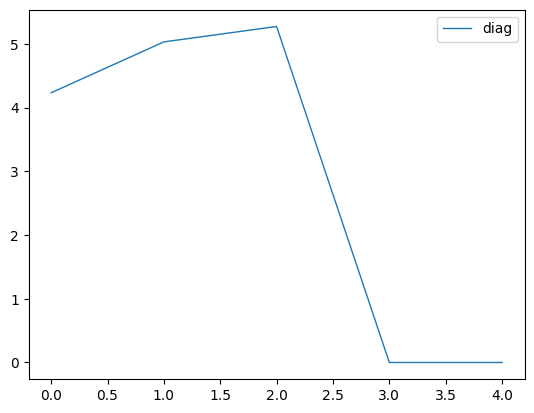

In [3]:
eigenvalues, eigenvectors = linalg.eig(true_H)
draw(dim_in, eigenvalues)

In [4]:
def plot_trend(stats, x_axis, y_axis, title, xlabel = None, ylabel = None):
    df = pd.DataFrame(stats)

    # Prepare the data for plotting
    plot_data = [df[y_axis][i] for i in range(len(df))]

    # Create the boxplot
    plt.boxplot(plot_data, labels=[str(x[x_axis]) for x in stats])

    # Add titles and labels
    plt.title(title)
    if xlabel is None:
        xlabel = x_axis
    if ylabel is None:
        ylabel = y_axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Show the plot
    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:01<00:05,  1.37s/it]

min mse: 0.5446299
time: 3.4715080441830795


 40%|████      | 2/5 [00:04<00:06,  2.28s/it]

min mse: 0.4812312
time: 4.651274612982567


 60%|██████    | 3/5 [00:12<00:09,  4.77s/it]

min mse: 0.44146526
time: 4.238219442299529


 80%|████████  | 4/5 [00:37<00:12, 12.88s/it]

min mse: 0.33505836
time: 4.722353678487814


100%|██████████| 5/5 [03:55<00:00, 47.07s/it]

min mse: 0.28493488
time: 4.736534637585981


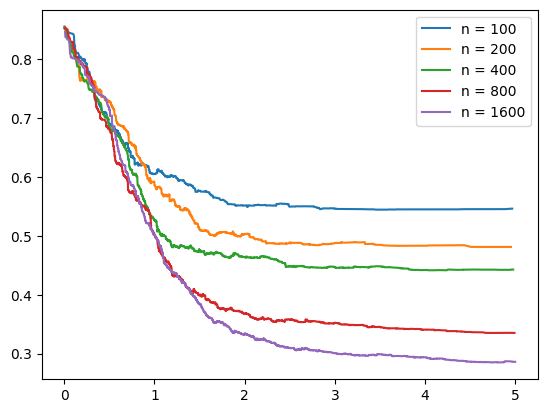

In [5]:
lifetime_max = 5
for n_sim in tqdm(sample_range):
    results = evaluate_all_lifetimes(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta)
    print("min mse: " + str(min(results['mse'])))
    print("time: " + str(results['times'][np.where(results['mse'] == min(results['mse']))[0][0]]))
    plt.plot(results['times'], results['mse'], label = 'n = ' + str(n_sim))
    plt.legend()

# With increasing lifetime

In [13]:
lifetime = 2

stats = []
for n_sim in sample_range:
    dist = {'n': n_sim, 'mse': [], 'dist': [], 'H': []}
    for trial in tqdm(range(5)):
        y_hat_test, history, X_bd_all = \
            one_run(x_train[:n_sim, ], y_train[:n_sim], x_test, M, lifetime, delta)
        dist['mse'].append(mean_squared_error(y_test, y_hat_test))
        H_0 = estimate_H_ind(x_train[:n_sim, ], y_train[:n_sim], X_bd_all, M, x_test, history, delta, y_hat_test)
        dist['dist'].append(norm(H_0 - true_H, ord = 2)/norm_H)
        dist['H'].append(H_0)
    lifetime = lifetime + 0.5
    print(dist['dist'])
    stats.append(dist)

100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


[10.348443, 6.183593, 5.3972044, 3.736651, 5.5399446]


100%|██████████| 5/5 [00:23<00:00,  4.66s/it]


[8.134721, 7.601253, 7.2308555, 7.3926396, 4.8789835]


100%|██████████| 5/5 [00:43<00:00,  8.71s/it]


[6.623998, 8.75497, 6.9335675, 8.34939, 8.08073]


100%|██████████| 5/5 [02:51<00:00, 34.31s/it]

[12.064265, 11.949018, 10.862885, 11.630592, 10.884792]


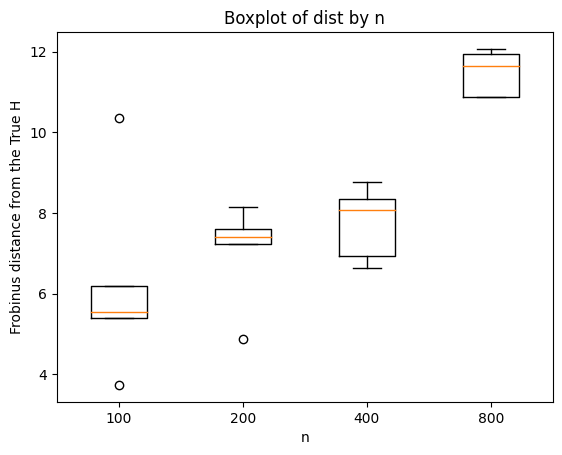

In [14]:
plot_trend(stats, 'n', 'dist', 'Boxplot of dist by n', ylabel='Frobinus distance from the True H')

In [16]:
lifetime = 2

alter = []
for i in range(4):
    dist = stats[i]
    alter_dist = {'n': sample_range[i], 'dist':[]}
    for trial in tqdm(range(5)):
        H_0 = dist['H'][trial]
        true_H_normalised = true_H/two_one_norm(true_H)
        H_0_normalised = H_0/two_one_norm(H_0)
        alter_dist['dist'].append(norm(true_H_normalised - H_0_normalised, ord = 2)/norm_H)
    lifetime = lifetime + 0.5
    print(alter_dist['dist'])
    alter.append(alter_dist)

100%|██████████| 5/5 [00:00<00:00, 2023.69it/s]


[0.3663068, 0.21359946, 0.25243467, 0.20951384, 0.20488381]


100%|██████████| 5/5 [00:00<00:00, 2145.86it/s]


[0.25482583, 0.23340726, 0.17326297, 0.16228297, 0.23190024]


100%|██████████| 5/5 [00:00<00:00, 2077.01it/s]


[0.18367401, 0.22241512, 0.18836923, 0.24263678, 0.19629487]


100%|██████████| 5/5 [00:00<00:00, 2858.71it/s]

[0.17059526, 0.19053854, 0.23616293, 0.16914897, 0.18523136]


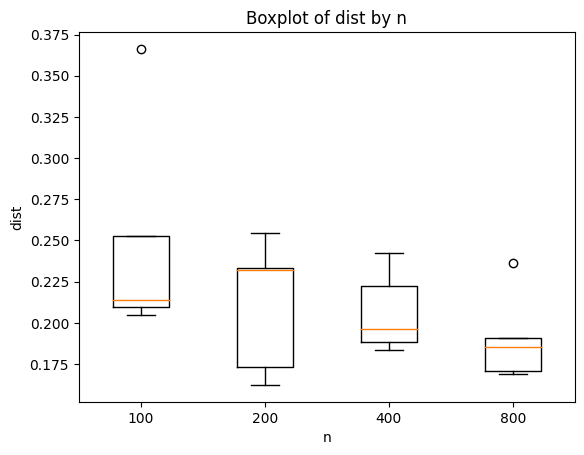

In [17]:
plot_trend(alter, 'n', 'dist', 'Boxplot of dist by n')

# Eliza's method for estimating gradients

In [18]:
def estimate_H_ind_(x_train, y_train, X_bd_all, M, X_test, history, delta, y_hat_test):
    dim_in = X_test.shape[1]
    N_test = X_test.shape[0]
    importance = []
    for dim in range(dim_in):
        try:
            x_eval = None
            y_eval = []
            x_diff = []
            subset_all = []
            for tree in range(M):
                temp = X_bd_all[tree,dim] - X_test
                subset = temp[:,dim] != 0
                subset_all = subset_all + list(subset)
                
                if sum(subset) > 0:
                    if x_eval is None:
                        x_eval = X_bd_all[tree,dim][subset]
                    else:
                        x_eval = np.vstack((x_eval, X_bd_all[tree,dim][subset]))
                    y_eval = y_eval + y_hat_test[subset].tolist()
                    x_diff = x_diff + list(temp[:,dim][subset])
            
            _, y_hat_eval = evaluate(x_train, y_train, x_eval, M, history, delta)
            y_eval = np.array(y_eval)
            x_diff = np.abs(x_diff)
            y_diff = populate_importance(subset_all, y_eval - y_hat_eval)
            x_diff = populate_importance(subset_all, x_diff)
            y_diff = np.reshape(y_diff, (N_test, M))
            x_diff = np.reshape(x_diff, (N_test, M))
            y_diff = np.mean(y_diff, axis = 1)
            x_diff = np.mean(x_diff, axis = 1)
            y_diff[x_diff == 0] = 0
            x_diff[x_diff == 0] = 1
            importance_temp = y_diff/x_diff
        except:
            importance_temp = np.zeros(N_test)
        importance.append(importance_temp)
    importance = np.vstack(importance)

    H = np.matmul(importance, np.transpose(importance))
    return H

lifetime = 2

stats = []
for n_sim in sample_range:
    dist = {'n': n_sim, 'mse': [], 'dist': [], 'H': []}
    for trial in tqdm(range(5)):
        y_hat_test, history, X_bd_all = \
            one_run(x_train[:n_sim, ], y_train[:n_sim], x_test, M, lifetime, delta)
        H_0 = estimate_H_ind_(x_train[:n_sim, ], y_train[:n_sim], X_bd_all, M, x_test, history, delta, y_hat_test)
        dist['dist'].append(norm(H_0 - true_H, ord = 2)/norm_H)
        dist['H'].append(H_0)
        dist['mse'].append(mean_squared_error(y_test, y_hat_test))
    lifetime = lifetime + 0.5
    print(dist['dist'])
    stats.append(dist)

100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


[9.424158, 21.4289, 11.602939, 8.35698, 12.118125]


100%|██████████| 5/5 [00:17<00:00,  3.59s/it]


[18.734056, 19.01878, 10.6034565, 16.277205, 11.611435]


100%|██████████| 5/5 [00:51<00:00, 10.27s/it]


[15.523657, 15.06774, 13.390723, 15.405711, 12.39468]


100%|██████████| 5/5 [02:42<00:00, 32.52s/it]

[15.080891, 18.407928, 13.344393, 17.75262, 15.954909]


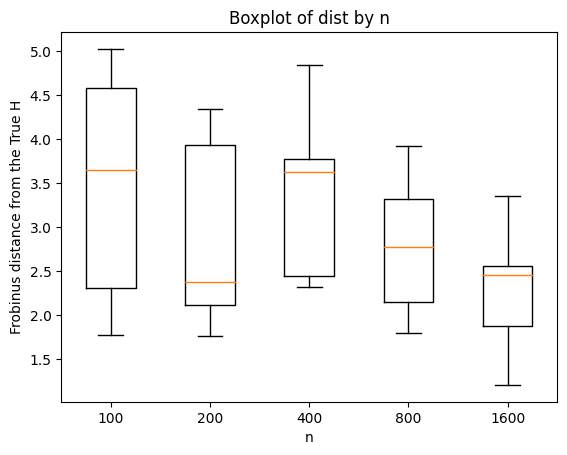

In [ ]:
plot_trend(stats, 'n', 'dist', 'Boxplot of dist by n', ylabel='Frobinus distance from the True H')

100%|██████████| 5/5 [00:00<00:00, 2148.72it/s]


[0.22399496, 0.39671147, 0.24254827, 0.18186481, 0.19361058]


100%|██████████| 5/5 [00:00<00:00, 1860.00it/s]


[0.1995879, 0.19921985, 0.21954937, 0.23201855, 0.19390391]


100%|██████████| 5/5 [00:00<00:00, 2158.67it/s]


[0.18001445, 0.21086301, 0.17086862, 0.18360646, 0.18678619]


100%|██████████| 5/5 [00:00<00:00, 2070.65it/s]

[0.18891495, 0.1853003, 0.1923698, 0.19160177, 0.22132349]


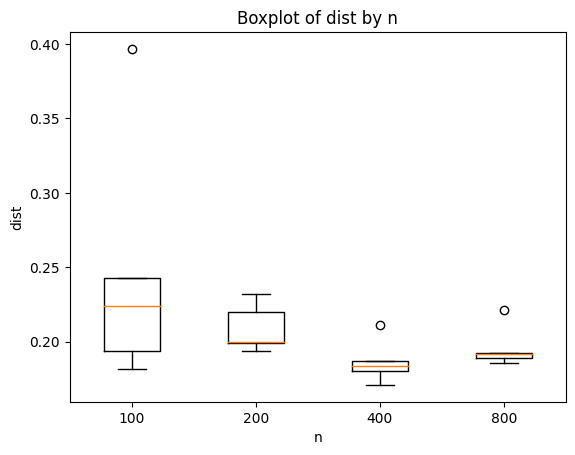

In [19]:
alter = []
for i in range(4):
    dist = stats[i]
    alter_dist = {'n': sample_range[i], 'dist':[]}
    for trial in tqdm(range(5)):
        H_0 = dist['H'][trial]
        true_H_normalised = true_H/two_one_norm(true_H)
        H_0_normalised = H_0/two_one_norm(H_0)
        alter_dist['dist'].append(norm(true_H_normalised - H_0_normalised, ord = 2)/norm_H)
    print(alter_dist['dist'])
    alter.append(alter_dist)

plot_trend(alter, 'n', 'dist', 'Boxplot of dist by n')